# Simple Chatbot

# 1 - Data Preprocessing (Personality chat datasets)

## 1.1. Download Dataset (Personality chat datasets)

In [0]:
# Install the PyDrive wrapper & import libraries.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Download 3 datasets.
downloaded = drive.CreateFile({'id': '1LPATP-3u2SFafaGuJUq0xV88Apa4UCG1'})
downloaded.GetContentFile('qna_chitchat_the_comic.tsv')  
print('Downloaded dataset 1')

downloaded = drive.CreateFile({'id': '1NvenGa9eBQ_7N6t0u93315Xygigw_M8f'})
downloaded.GetContentFile('qna_chitchat_the_professional.tsv')  
print('Downloaded dataset 2')

downloaded = drive.CreateFile({'id': '1tAC1k0Rj6a24V7h6QBdxGtBsyyTafRIj'})
downloaded.GetContentFile('qna_chitchat_the_friend.tsv')  
print('Downloaded dataset 3')

Downloaded dataset 1
Downloaded dataset 2
Downloaded dataset 3


## 1.2. Preprocess data (Personality chat datasets)

### 1) Decapitalisation
- Turn all the charactors into lowercase can reduce the vocabulary size. It also make the following preprocess easier by using one lowercase representation for the same words.

### 2) Expand common contractions
- Some of the samples in the training datasets have contractions while some are not. Expanding commnon contractions could reduce the variation of the representation of the same meaning which could be a benefitial preprocessing technique especially in these small datasets.

### 3) Remove punctuations 
- Majority of the samples in the datasets are short question answering, therefore,  '?' or '.' is not that different across different data points. 
- There are not many punctuations in the training datasets. In order to maintain good performance in the acutal case which users might type lots of unseen punctuations, it's better to remove puncuations in the preprocessing before take the data into the model.
- Remove digit numbers because it is simple chatbot which is not capable to do conversation with different digits.

### 4) Tokenization 
- Tensorflow Keras tokenization library is used in seq2seq model dataset preprocessing. The tokenizer is fitted in word embedding process which one to one mapping with the word embedding vectors. It could directly transform the sentences into corresponding numerical representations in the seq2seq model.

In [0]:
import pandas as pd
import re
from nltk.tokenize import TweetTokenizer

# Read datasets
comic_dataset = pd.read_csv("qna_chitchat_the_comic.tsv", sep="\t")
professional_dataset = pd.read_csv("qna_chitchat_the_professional.tsv",sep="\t")
friend_dataset = pd.read_csv("qna_chitchat_the_friend.tsv",sep="\t")

# common English contractions dict data is from Lab05 materials.

contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", 
                    "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
                    "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", 
                    "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", 
                    "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", 
                    "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", 
                    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", 
                    "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
                    "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                    "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", 
                    "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
                    "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
                    "so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", 
                    "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", 
                    "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", 
                    "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", 
                    "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", 
                    "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", 
                    "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", 
                    "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", 
                    "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

# Expand common English contractions
def expand_contractions(text):
  
    compiled = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    def replace(contraction):
        return contraction_dict[contraction.group(0)]
    expanded = compiled.sub(replace, text)
    
    return expanded

# Clean the data
def cleaning_data(text):
    text = text.lower() # decapitalisation
    text = expand_contractions(text) # expand contractions
    text = re.sub(r'[^\w\s]','', text) # remove punctuations
    text = re.sub('\d', '', text) # remove digits
    
    return text


In [0]:
'''
Answer data preparation: generate answer dictionary
'''
def answer_preparation(answers):
    # Extract unique answer value
    unique_answer = list(set(answers))  
    # Add special tokens in the unique answer list
    unique_answer.append('_B_')
    unique_answer.append('_E_')
    unique_answer.append('_U_')
    # Generate dictionary for answer data.
    answer_word2index = {word: index for index, word in enumerate(unique_answer)}
    answer_index2word = {index: word for index, word in enumerate(unique_answer)}
    
    return answer_word2index, answer_index2word

In [0]:

'''
Preprocess dataset before training the seq2seq model
'''
def Preprocess_Data(dataset):
    questions, answers = list(), list()
    
    for index, row in dataset.iterrows():   
        questions.append(cleaning_data(row.Question)) # clean the data
        answers.append(row.Answer)
    
    # generate answer dictionary for decoding
    answer_word2index, answer_index2word = answer_preparation(answers)
    
    # return training data
    train_data = {'questions':questions, 
                  'answers':answers, 
                  'answer_word2index':answer_word2index, 
                  'answer_index2word':answer_index2word
                 }       
    return train_data 

'''
Preprocess each dataset
'''
comic = Preprocess_Data(comic_dataset)
professional = Preprocess_Data(professional_dataset)
friend = Preprocess_Data(friend_dataset)

# 2 - Model Implementation

## 2.1. Word Embeddings

####  Word2Vec with SkipGram is implemented as a Word Embedding model.
- As shown the Graph below, the chatbot training datasets consist of short sentences with relatively simple word, therefore, word level of embeddings is enough for this task. It is not necessary to use subwords.
- Majority of sentences have 2 to 4 words in the training datasets, the SkipGram with window sides 2 is appropriate for training the word embeddings and used in chatbot training later on.
- For the Answer sentences in the chat datasets are not used in word embedding training. The answers will use one hot word vector instead of word embeddings because they are sentence level and vocabularies of sentence are limited in this case, thus it is not necessary to generate sentence level embeddings. 

                 0
count  1971.000000
mean      3.786910
std       1.600524
min       1.000000
25%       3.000000
50%       4.000000
75%       5.000000
max      11.000000


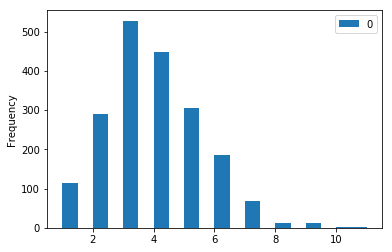

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Combine three personality chat datasets
chat_dataset = pd.concat([comic_dataset, professional_dataset, friend_dataset])

# Calculate length of each sentences in chat_dataset.Question
sentence_len = [len(sentence.split()) for sentence in chat_dataset.Question]

# Distribution of the length of each sentences in the training datasets.
sentence_len_df = pd.DataFrame(sentence_len)
print(sentence_len_df.describe())

# plot length distribution
sentence_len_df.plot.hist(bins=20)
plt.show()

### 2.1.1. Download Dataset for Word Embeddings



'Microsoft BotBuilder chat datasets' Questions and 'Cornell Movie Dialog Corpus' dataset are used for training Word Embeddings.
- The movie plot dataset is used additionally because the chatbot datasets are relatively small and vocabulary is limited (as shown in 1.2.1, the vocabulary size is 506 in chat_dataset). 
- The whole movie dialog datasets contain nearly 30 thousands lines, which takes too much time to train the model, therefore, half of the datasets(15,000) are selected as the training data in the word embeddings model. Together with the chat datasets, final datasets have 16,971 sentences. 

*Benefits*:

- Enlarge vocabulary size which could reduce the number of unknown words when in the real test cases.
- Achieve better Word Embedding vectors by training with larger datasets.

In [0]:
# 1. Download movie dialog datasets for word embedding
downloaded = drive.CreateFile({'id':'1ah9IvYyW5KxcRlYaYTDMvdYzK7hvAgbE'}) 
downloaded.GetContentFile("movie_lines.txt")  

#2. Use three personality datasets above together with movie dialog datasets.

### 2.1.2. Data Preprocessing for Word Embeddings

 - Same as the Personality chat datasets preprocessing, decapitalisation, expanding common contractions and removing punctuations techniques are used in Data Preprocessing for Word Embeddings because there is no any punctuation, contraction or upper case letter in the traning and real test process, therefore, it is not necessory to add them into word embeddings.
 
- Additionally, null values are removed in the first data cleaning step for movie plot data.
- Keras tokenizer is used in tokenize the training datasets. It not only tokenize the sequence into individual words efficiently but also turn all the vocabularies into unique numerical representations which would be used in the training processs later on.


In [0]:
# Combine movie dialog datasets and three chat datasets.
all_data =[]

# Read movie dialog dataset
count=0
with open('movie_lines.txt', 'r', errors='ignore') as f:
    for line in f:
        # extract sentences
        l = line.strip().split('+++$+++') 
        if len(l) == 5:
            all_data.append(cleaning_data(l[4])) 
            
            count +=1
        if count >=15000: # only extract half of the datapoints 15000 out of 30000
            break
            
# Add chat datasets into all_data            
for sentence in chat_dataset.Question:
    all_data.append(cleaning_data(sentence))               

In [0]:
# Tokenize
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer() 

# tokenizer fits on all training data
tokenizer.fit_on_texts(all_data) 

# tokenize the training data 
all_data_tokenized = tokenizer.texts_to_sequences(all_data)

In [0]:
'''
Generate Word Embedding training dataset
'''
input_X, label_Y = list(), list()

for sentence in all_data_tokenized:
  
    if len(sentence) ==1: # for the sentences only contain one words.
        input_X.append(sentence[0])
        label_Y.append(sentence[0])

    else:
        for i in range(1,len(sentence)-2):
            # second word as a target word
            input_X.append(sentence[i])
            label_Y.append(sentence[i-1])

            
            if i>1: # from third word as a target word
                input_X.append(sentence[i])
                label_Y.append(sentence[i-2])
                
            if i+1< len(sentence): # check if reach at the end of the sentence
                input_X.append(sentence[i])
                label_Y.append(sentence[i+1])
                
            if i+2 < len(sentence): # check if reach at the end of the sentence
                input_X.append(sentence[i])
                label_Y.append(sentence[i+2])               
                

In [0]:
# Define a function to generate batch inputs
def prepare_batch(input_X, label_Y, batch_size):
    
    batch_inputs = []
    
    for batch_i in range(0, len(input_X)//batch_size): 
        start_i = batch_i*batch_size
        batch_input = np.array(input_X[start_i:start_i + batch_size])
        batch_label = np.array(label_Y[start_i:start_i + batch_size]).reshape(batch_size, 1)        
        batch_inputs.append((batch_input,batch_label))
   
    return batch_inputs 

### 2.1.3. Build Word Embeddings Model

**Embedding size: 200**
- Choose bigger embedding size to better represent the word. However, bigger embedding size is computationally expensive and also not necessary for small vocabulary. In this case, for total vacabulary size =11,314 and training dataset size =495,668 , embedding size  200 performs great in terms of result accuracy and computational efficiency.

**Learning rate: 0.008**
**Epoch: 18**

- Figure Below is Visualisation of epoch-cost graph during the Word Embeddings model training process on different learning rates.
As shown in the figure, learning rate 0.008 and epoch 18 is the optimal choice of hyperparameters.
- Compared on same condition: embedding_size = 200, batch_size = 256, epoch = 20
- learning rate = [0.005, 0.008, 0.01, 0.05]


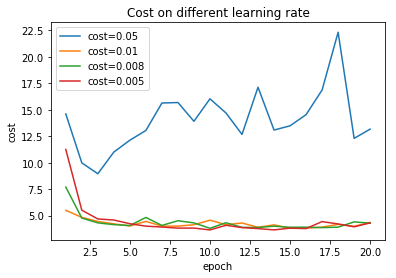

In [0]:
# plot epoch-cost in different learning rate settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

epoch_20 = [i+1 for i in range(20)]

# learning_rate = 0.05
cost_005 = [14.606675, 9.983141, 8.957794, 11.007188, 12.1262245, 13.044088, 15.638842, 15.686038, 13.912088, 16.034172, 14.697906, 12.672653, 17.132229, 13.085133, 13.486287, 14.541117, 16.869387, 22.326859, 12.300587, 13.172368]

# learning_rate = 0.01
cost_001 = [5.501668, 4.833394, 4.4415703, 4.2230067, 4.0181265, 4.4546504, 4.0039854, 4.0096474, 4.1387367, 4.5669823, 4.1412916, 4.301157, 3.8959527, 4.1269712, 3.796802, 3.814628, 3.9161959, 4.169813, 3.9905632, 4.353211]

# learning_rate = 0.008
cost_0008 = [7.6957035, 4.770343, 4.3139243, 4.1474323, 4.061558, 4.8282847, 4.07117, 4.5168314, 4.3105745, 3.8014207, 4.330092, 3.8882437, 3.8810558, 4.0024176, 3.8996267, 3.90563, 3.8651938, 3.91022, 4.4067707, 4.285951]

# learning_rate = 0.005
cost_0005 = [11.251139, 5.51412, 4.6841617, 4.5836244, 4.2326894, 4.005059, 3.9186711, 3.8187976, 3.8207495, 3.6481996, 4.0861535, 3.8690357, 3.7734966, 3.6502302, 3.8161292, 3.7751307, 4.4331813, 4.2135196, 3.9421976, 4.3114514]

plt.plot(epoch_20, cost_005, label='cost=0.05')
plt.plot(epoch_20, cost_001, label='cost=0.01')
plt.plot(epoch_20, cost_0008, label='cost=0.008')
plt.plot(epoch_20, cost_0005, label='cost=0.005')

plt.legend()
plt.title('Cost on different learning rate'); 
plt.xlabel('epoch'); 
plt.ylabel('cost')
plt.show()

In [0]:
# Build word embedding model
import tensorflow as tf

embedding_size = 200 
batch_size = 256 
learning_rate = 0.008

sample_size = 128 # sampling size for loss function
vocabulary_size = len(tokenizer.word_index) + 1

tf.reset_default_graph()

inputs = tf.placeholder(tf.int32, shape=[batch_size], name='inputs')
labels = tf.placeholder(tf.int32, shape=[batch_size, 1], name='labels')

# word2vec Model
embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0),name='embeddings')

embedding_vectors = tf.nn.embedding_lookup(embeddings, inputs, name='embedding_vectors')

# weight and bias for nce_loss() function
weights = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0), name='weights')
biases = tf.Variable(tf.zeros([vocabulary_size]), name='biases')

cost_op = tf.reduce_mean(tf.nn.nce_loss(
    weights, biases, labels, embedding_vectors, sample_size, vocabulary_size))

train_op = tf.train.AdamOptimizer(learning_rate).minimize(cost_op)


### 2.1.4. Train Word Embeddings Model

In [0]:
'''Training Word Embeddings Model'''
epochs = 18
display_interval = 1
    
init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)
# epoch_graph, cost_graph = [], [] #used in justification visualization.

for epoch in range(epochs):

    for (input_batch, label_batch) in prepare_batch(input_X, label_Y, batch_size): 

        sess.run(train_op, feed_dict={inputs:input_batch, labels:label_batch})    

    if epoch % display_interval == 0 :
        # calculate the cost of the current model
        cost = sess.run(cost_op, feed_dict={inputs:input_batch, labels:label_batch})
        print("Epoch " + str(epoch) + ", Cost= " + "{:.4f}".format(cost))
        
        # save epoch and cost for visualisation, used in justification visualization.
#         epoch_graph.append(epoch)
#         cost_graph.append(cost)

Epoch 0, Cost= 6.4489
Epoch 1, Cost= 5.5970
Epoch 2, Cost= 4.2305
Epoch 3, Cost= 4.9951
Epoch 4, Cost= 4.5621
Epoch 5, Cost= 3.7645
Epoch 6, Cost= 4.6755
Epoch 7, Cost= 4.1537
Epoch 8, Cost= 4.3851
Epoch 9, Cost= 4.6676
Epoch 10, Cost= 4.5507
Epoch 11, Cost= 3.6952
Epoch 12, Cost= 4.3434
Epoch 13, Cost= 4.0330
Epoch 14, Cost= 4.2604
Epoch 15, Cost= 3.9658
Epoch 16, Cost= 3.9862
Epoch 17, Cost= 4.5958


In [0]:
# learned embeddings
with sess.as_default():
    embedding_matrix = embeddings.eval()
embedding_matrix

array([[ 0.72747207, -0.57962656,  0.89630485, ..., -0.01899862,
         0.19822645,  0.41107512],
       [ 0.26535383,  0.1029154 ,  0.1448514 , ...,  0.20774543,
        -0.38749447, -0.06851911],
       [ 0.3053288 ,  0.08841152,  0.3292596 , ...,  0.33441165,
        -0.27151206, -0.02670388],
       ...,
       [-0.9379034 ,  0.83551145, -0.4309504 , ...,  0.64013076,
         0.8058648 ,  0.1853602 ],
       [ 0.82260543,  2.362698  , -0.26143828, ..., -0.48504528,
        -0.05656002, -0.40946335],
       [ 1.5368797 ,  0.28561488,  0.719077  , ..., -0.70566887,
         1.457389  , -1.0534751 ]], dtype=float32)

### 2.1.5. Save Word Embeddings Model

In [0]:
'''
Save the model in the colab local server
'''
# Save the word embeddings model
saver = tf.train.Saver([embeddings])
save_path = saver.save(sess, './embedding_model/embeddings')
print("Word Embeddings Model saved in path: %s" % save_path)

# Save tokenizer, answer dictionary.
import pickle
pickle.dump(tokenizer, open('./embedding_model/tokenizer.pkl','wb'))
print("Question tokenizer is saved successfully.")

Word Embeddings Model saved in path: ./embedding_model/embeddings
Question tokenizer is saved successfully.


In [0]:
# Install the PyDrive wrapper & import libraries.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

'''
Upload the Word Embeddings Model in the colab local server to Google Drive
'''
import os
directory = "/content/embedding_model/"
filelist = os.listdir(directory) # read files in the directory

for file_name in filelist:
    # Upload model files
    try: 
        uploaded = drive.CreateFile()
        uploaded.SetContentFile(file_name)
        uploaded.Upload()
        
        print('{} uploaded with ID {}.\n'.format(file_name, uploaded.get('id')))
    except Exception:
        print('')

checkpoint uploaded with ID 1TfBc1vVYI40jvU7poPTXPJ8AnaOpoJ49.

embeddings.meta uploaded with ID 11qhzF4RmTzJaJjAHhUGK9yc4jpYLJtdk.

embeddings.index uploaded with ID 1aTmFyFjPXginLO2COVdj3_tuO2HyCFZT.

embeddings.data-00000-of-00001 uploaded with ID 1f-TJXVVEIkttDZCIIhNLB0sLnp125O5k.


tokenizer.pkl uploaded with ID 1wfH4pdilN4GvnwH_lwoPXiGQhO1H95UB.



### 2.1.6. Load Word Embeddings Model

In [0]:
def Load_Word_Embeddings_Model():
    print('Downloading word embeddings model...')
    # Download the Word Embeddings Model from Google Drive
    downloaded = drive.CreateFile({'id': '11qhzF4RmTzJaJjAHhUGK9yc4jpYLJtdk'})
    downloaded.GetContentFile('embeddings.meta')  

    downloaded = drive.CreateFile({'id': '1aTmFyFjPXginLO2COVdj3_tuO2HyCFZT'})
    downloaded.GetContentFile('embeddings.index')    
    
    downloaded = drive.CreateFile({'id': '1f-TJXVVEIkttDZCIIhNLB0sLnp125O5k'})
    downloaded.GetContentFile('embeddings.data-00000-of-00001') 
    
    downloaded = drive.CreateFile({'id': '1TfBc1vVYI40jvU7poPTXPJ8AnaOpoJ49'})
    downloaded.GetContentFile('checkpoint') 
    
    downloaded = drive.CreateFile({'id': '1wfH4pdilN4GvnwH_lwoPXiGQhO1H95UB'})
    downloaded.GetContentFile('tokenizer.pkl') 
    
    print('Word embeddings model is successfully downloaded.')
    
    # Load the model to colab local server
    print('Loading the model to local server...')
    saver = tf.train.import_meta_graph('./embeddings.meta')

    with tf.Session() as sess:
        saver.restore(sess, "./embeddings")
        graph = tf.get_default_graph()
        embeddings = graph.get_tensor_by_name("embeddings:0")
        embedding_matrix = embeddings.eval()

    tokenizer = pickle.load(open("./tokenizer.pkl","rb"))
    
    print('Word Embeddings Model is successfully loaded.')  
    
    return embedding_matrix, tokenizer

In [0]:
import tensorflow as tf
import pickle    
embedding_matrix, tokenizer = Load_Word_Embeddings_Model()

Word embeddings model is successfully downloaded.
Loading the model to local server...
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./embeddings
Word Embeddings Model is successfully loaded.


## 2.2. Seq2Seq model

### 2.2.1. Apply/Import Word Embedding Model

In [0]:
'''
Learned embeddings imported as 'embedding_matrix' in the loading Word Embeddings Model section.
The tokenizer fitted in word embedding model training process, imported as 'tokenizer'
'''
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import utils

# Define a function of tokenization and padding for input data.
def tokenization(sentences):
  
    # Tokenize all sentences using tokenizer from previous word embeddings model
    tokenized_sentences = tokenizer.texts_to_sequences(sentences)
    
    # calculate max length of sentence
    maxlen = max([len(sentence) for sentence in tokenized_sentences])

    # padding the sentences with max length
    padded_sentences = pad_sequences(tokenized_sentences, maxlen = maxlen) 
    
    return padded_sentences, maxlen

In [0]:
'''
Generate encoder input, decoder input and target data for seq2seq model training process.
'''
import numpy as np 

def get_train_data(dataset):
  
    questions = dataset['questions']  
    answers = dataset['answers']
    answer_word2index = dataset['answer_word2index']
    answer_index2word = {index:word for word, index in answer_word2index.items()}
    
    # generate encoder inputs by tokenization and padding
    # output max length of encoder inputs - maxlen      
    padded, maxlen = tokenization(questions)
    encoder_input_data = padded
        
    # calculate total number of decoder outputs. 
    n_class = len(answer_word2index)
    
    # generate decoder inputs
    decoder_input_data, decoder_target_data = list(), list()
    
    for answer in answers:         
        # generate decoder input data 
        dec_input = [answer_word2index['_B_']]
        dec_input.append(answer_word2index[answer])
        decoder_input_data.append(np.eye(n_class)[dec_input])
         
        # generate decoder target data
        target = dec_input[1:]
        target.append(answer_word2index['_E_']) 
        decoder_target_data.append(target)

    decoder_input_data = np.array(decoder_input_data)
    decoder_target_data = np.array(decoder_target_data)
    
    return encoder_input_data, decoder_input_data, decoder_target_data, answer_word2index, answer_index2word, maxlen, n_class

### 2.2.2. Build Seq2Seq Model

In [0]:
'''
Build Seq2Seq Model using Tensorflow Keras
'''
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Input, Embedding, TimeDistributed,Dropout

def build_seq2seq_model(maxlen, n_class):
    n_units=64
    num_en_words = embedding_matrix.shape[0]
    embedding_dim = embedding_matrix.shape[1]

    # encoder layers:
    encoder_input = Input(shape=(None,))
    encoder_embedding = Embedding(num_en_words,
                        embedding_dim,
                        input_length=maxlen,
                        weights=[embedding_matrix], trainable=False)(encoder_input)
    encoder_LSTM = LSTM(n_units, recurrent_dropout=0.5, return_sequences=True, return_state=True)
    encoder_outputs, state_h, state_c = encoder_LSTM(encoder_embedding) 
    encoder_states = [state_h, state_c]

    # decoder layers
    decoder_input = Input(shape=(None, n_class))
    decoder_LSTM = LSTM(n_units, recurrent_dropout=0.5, return_sequences=True, return_state=True)
    decoder,_,_ = decoder_LSTM(decoder_input, initial_state = encoder_states)
    decoder_dense = Dense(n_class, activation='linear', name='decoder_output') 
    decoder_outputs = decoder_dense(decoder)  
    
    # Define encoder model
    encoder_model = Model(encoder_input, encoder_states)

    # Define training model
    model = Model([encoder_input, decoder_input], decoder_outputs)

    # Define decoder model
    dec_h = Input(shape=(n_units,))
    dec_c = Input(shape=(n_units,))
    dec_states_inputs = [dec_h, dec_c]
    decoder_outputs, state_h, state_c = decoder_LSTM(decoder_input, initial_state=dec_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)

    decoder_model = Model([decoder_input] + dec_states_inputs, [decoder_outputs] + decoder_states)
#     model.summary()
    
    return model, encoder_model, decoder_model

### 2.2.3. Train Seq2Seq Model

Train the model with different batch size, learning rate and epoch. The 'comic' datasets was used in tuning models.
The results are shown as below figures.

***batch size:*** 

- Batch size 64, 128, 256 were choen to perform hyperparameter tuning. Based on the result shown in the figure, after enough iteration, loss from different batch sizes are similar. In this case, we will run at leat 200 epochs, it means the batch size is not critical issues. Therefore batch size = 128 is chosen as a default value.

***learning rate:*** 
- As shown in the figure below, the model was trained and validated with learing rate: 0.0005, 0.001, 0.005, 0.01. After training through 300 epoch, learning rate 0.005 and 0.01 are already reached minimum loss from epoch 100 and after epoch 300 they are still keep lowest loss, while learning rate 0.0005 is too slow to reduce the loss. Therefore, learning rate 0.01 was chosen to train final model in terms of effiency.

***epoch:*** 
- After trained with 300 epochs, the model already reached minimun after 100 epochs with learning rate 0.01, Thus, epoch=200 is enough in this task. 

Final hyperparameter: batch size = 128, learning rate = 0.01 , epoch =200


In [0]:
'''
Below training function is only for visualize learning cruve with different learning rate.
'''
from keras.optimizers import Adam
import matplotlib.pyplot as plt
%matplotlib inline

# Generate training data - select comic data as a sample data for hyperparameter tuning.
encoder_input_data, decoder_input_data, decoder_target_data,\
        answer_word2index, answer_index2word, \
                maxlen, n_class = get_train_data(comic)
# # Build model
# model, encoder_model, decoder_model = build_seq2seq_model(maxlen, n_class)

# define loss function: use sparse_softmax_cross_entropy_with_logits
def sparse_loss(targets, decoder_outputs):
    return tf.nn.sparse_softmax_cross_entropy_with_logits(labels=targets, logits=decoder_outputs)

def tune_model(learning_rate=0.005, batch_size = 128, epochs = 300):
    
    # Build model
    model, encoder_model, decoder_model = build_seq2seq_model(maxlen, n_class)
    # Run training
    decoder_target = tf.placeholder(dtype='int32', shape=(None, n_class))    
    model.compile(optimizer=Adam(lr=learning_rate),
                    loss=sparse_loss,
                    target_tensors=[decoder_target])

    model_fit = model.fit(x=[encoder_input_data, decoder_input_data], y=decoder_target_data,
                batch_size=batch_size, epochs=epochs, verbose=0)
    
    loss = model_fit.history['loss']
    
    return loss

training with batch_size = 64
training with batch_size = 128
training with batch_size = 256


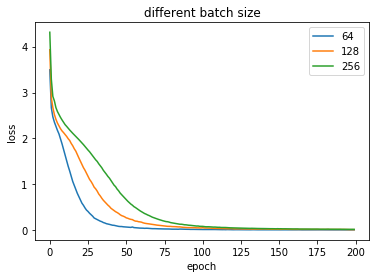

In [0]:
'''
Learning curve with different batch size.
'''
batch_size_list = [64,128,256] 

for batch_size in batch_size_list:
    print('training with batch_size = {}'.format(batch_size))
    loss = tune_model(learning_rate=0.005, batch_size = batch_size, epochs = 200)
    epoch = [i for i in range(200)]
    plt.plot(epoch, loss, label=str(batch_size))
    
plt.legend()
plt.title('different batch size');
plt.xlabel('epoch'); 
plt.ylabel('loss')
plt.show() 

training with learning_rate = 0.0005
training with learning_rate = 0.001
training with learning_rate = 0.005
training with learning_rate = 0.01


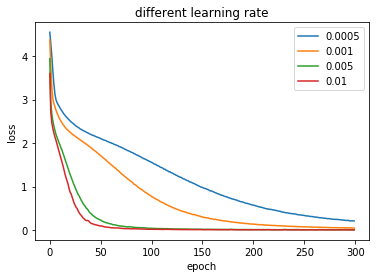

In [0]:
'''
Learning curve with different learning rate.
'''
learning_rate_list = [0.0005, 0.001, 0.005, 0.01] 

for learning_rate in learning_rate_list:
    print('training with learning_rate = {}'.format(learning_rate))
    loss = tune_model(learning_rate=learning_rate, epochs = 300)
    epoch = [i for i in range(300)]
    plt.plot(epoch, loss, label=str(learning_rate))

plt.legend()
plt.title('different learning rate');
plt.xlabel('epoch'); 
plt.ylabel('loss')
plt.show() 

***Below is actual training model***

batch size = 128, learning rate = 0.01 , epoch =200

In [0]:
from keras.optimizers import Adam

# define loss function: use sparse_softmax_cross_entropy_with_logits
def sparse_loss(targets, decoder_outputs):
    return tf.nn.sparse_softmax_cross_entropy_with_logits(labels=targets, logits=decoder_outputs)

def Train_Seq2Seq_Model(dataset, learning_rate=0.01, batch_size = 128, epochs = 200):
    
    # Generate training data
    encoder_input_data, decoder_input_data, decoder_target_data, \
            answer_word2index, answer_index2word, \
                    maxlen, n_class = get_train_data(dataset)      
    print('maxlen: {}, n_class: {} \n'.format(maxlen, n_class))
    
    # Build model
    model, encoder_model, decoder_model = build_seq2seq_model(maxlen, n_class)
    model.summary()
    
    # Run training
    decoder_target = tf.placeholder(dtype='int32', shape=(None, n_class))    
    model.compile(optimizer=Adam(lr=learning_rate),
                    loss=sparse_loss,
                    target_tensors=[decoder_target])

    model.fit(x = [encoder_input_data, decoder_input_data], y = decoder_target_data,
          batch_size=batch_size, epochs=epochs) 
    
    return encoder_model, decoder_model, answer_word2index, answer_index2word, maxlen, n_class

**Train three personality chat models**

In [0]:
# train the model
print("-----------start to train Professional chatbot------------")
pro_model = Train_Seq2Seq_Model(professional)

# unpack model to save seperately later.
pro_enc_model, pro_dec_model, pro_answer_word2index, pro_answer_index2word, maxlen, n_class = pro_model

-----------start to train Professional chatbot------------
maxlen: 11, n_class: 100 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_81 (InputLayer)           (None, None)         0                                            
__________________________________________________________________________________________________
embedding_21 (Embedding)        (None, 11, 200)      2263000     input_81[0][0]                   
__________________________________________________________________________________________________
input_82 (InputLayer)           (None, None, 100)    0                                            
__________________________________________________________________________________________________
lstm_41 (LSTM)                  [(None, 11, 64), (No 67840       embedding_21[0][0]               
_______________________

In [0]:
# train model
print("-----------start to train Comic chatbot------------")
comic_model = Train_Seq2Seq_Model(comic)

# unpack model
comic_enc_model, comic_dec_model, comic_answer_word2index, comic_answer_index2word, maxlen, n_class = comic_model

-----------start to train Comic chatbot------------
maxlen: 11, n_class: 100 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_85 (InputLayer)           (None, None)         0                                            
__________________________________________________________________________________________________
embedding_22 (Embedding)        (None, 11, 200)      2263000     input_85[0][0]                   
__________________________________________________________________________________________________
input_86 (InputLayer)           (None, None, 100)    0                                            
__________________________________________________________________________________________________
lstm_43 (LSTM)                  [(None, 11, 64), (No 67840       embedding_22[0][0]               
______________________________

In [0]:
# train model
print("-----------start to train Friend chatbot------------")
friend_model = Train_Seq2Seq_Model(friend)  

# unpack model
friend_enc_model, friend_dec_model, friend_answer_word2index, friend_answer_index2word, maxlen, n_class = friend_model      

-----------start to train Friend chatbot------------
maxlen: 11, n_class: 101 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_89 (InputLayer)           (None, None)         0                                            
__________________________________________________________________________________________________
embedding_23 (Embedding)        (None, 11, 200)      2263000     input_89[0][0]                   
__________________________________________________________________________________________________
input_90 (InputLayer)           (None, None, 101)    0                                            
__________________________________________________________________________________________________
lstm_45 (LSTM)                  [(None, 11, 64), (No 67840       embedding_23[0][0]               
_____________________________

### 2.2.4. Save Seq2Seq Model

In [0]:
'''
Save models in the local server
'''
# Save encoder models and decoder models of three personality chatbot
for models, model_name in [(pro_enc_model,'pro_enc_model'), (pro_dec_model,'pro_dec_model'), 
                   (comic_enc_model,'comic_enc_model'), (comic_dec_model,'comic_dec_model'),
                   (friend_enc_model,'friend_enc_model'), (friend_dec_model,'friend_dec_model')]:
  
    with open('./{}.json'.format(model_name), 'w', encoding='utf8') as f:
        f.write(models.to_json())
    models.save_weights('{}_weights.h5'.format(model_name))
print("Encoder and decoder models are saved successfully.")
    
# Save answer decoder file
import pickle
for answer_decoder, name in [(pro_answer_word2index, 'pro_answer_word2index'),
                             (comic_answer_word2index, 'comic_answer_word2index'),
                             (friend_answer_word2index, 'friend_answer_word2index')]:
    pickle.dump(answer_decoder, open('./{}.pkl'.format(name),'wb'))
print("Answer decoders are saved successfully.")


Encoder and decoder models are saved successfully.
Answer decoders are saved successfully.


/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer lstm_42 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'input_83:0' shape=(?, 64) dtype=float32>, <tf.Tensor 'input_84:0' shape=(?, 64) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer lstm_44 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'input_87:0' shape=(?, 64) dtype=float32>, <tf.Tensor 'input_88:0' shape=(?, 64) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer lstm_46 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'input_91:0' sha

In [0]:

# Install the PyDrive wrapper & import libraries.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# The model has already been saved in the colab local server in the training step after training.
# Upload the Seq2Seq Model in the colab local server to Google Drive
import os

directory = "/content/"
filelist = os.listdir(directory) # read files in the directory

for file_name in filelist:
    # Upload model files
    try:
        if file_name.startswith('pro_'):
            uploaded = drive.CreateFile()
            uploaded.SetContentFile(file_name)
            uploaded.Upload()

            print('{} uploaded with ID {}.\n'.format(file_name, uploaded.get('id')))
        
        if file_name.startswith('comic_'):
            uploaded = drive.CreateFile()
            uploaded.SetContentFile(file_name)
            uploaded.Upload()

            print('{} uploaded with ID {}.\n'.format(file_name, uploaded.get('id')))
        
        if file_name.startswith('friend_'):
            uploaded = drive.CreateFile()
            uploaded.SetContentFile(file_name)
            uploaded.Upload()

            print('{} uploaded with ID {}.\n'.format(file_name, uploaded.get('id')))
        
    except Exception:
        print('')         

pro_answer_word2index.pkl uploaded with ID 1bL1h-HexAuEAzKA7jtnABl5wAw6KVf0x.

friend_enc_model_weights.h5 uploaded with ID 1OVO17bNtlvYirjCQXJdIpX52aMbeE3e8.

comic_dec_model_weights.h5 uploaded with ID 1fVwKYsW3MeOcxQEUt6TvaiX2owzF0KJo.

pro_dec_model.json uploaded with ID 1uMOMFDPrEwP5qoRnfFDwE9iABw19ZhUP.

comic_dec_model.json uploaded with ID 1ECVpI7ds4l1Zw7b8OkW4CrNu36ZEZ00O.

comic_enc_model.json uploaded with ID 1i2qjLP1dR14DHYHQphEenK74yrIoJqPd.

pro_enc_model.json uploaded with ID 19L3N0OLPhpDc1raV6WUAP_JVaz5Q8OBB.

friend_answer_word2index.pkl uploaded with ID 11A-c_M3SDhkfmYAJeo-wX9vCGzWfvHhT.

friend_dec_model_weights.h5 uploaded with ID 1o4D6cbVakdi4Ugp1B-UMFhQXqas1tdo2.

pro_dec_model_weights.h5 uploaded with ID 1IS1P3itGeIix5Nsjkdg2se4XkAo5o_ot.

comic_answer_word2index.pkl uploaded with ID 15kJAE2g22C2H13WEIc70uJhq7OO-Glr_.

pro_enc_model_weights.h5 uploaded with ID 115R0SwPSYIBhY90z8qwP8tceRjmmzFtN.

friend_enc_model.json uploaded with ID 14XNaJKjVOk8VQKVlQCwzmHFFE3et

### 2.2.5. Load Seq2Seq Model

In [0]:
def Download_Seq2Seq_Model():
    print('Downloading...')
    # Download the Word Embeddings Model from Google Drive
    # This file_id is the final version of the model
 
    # professional chatbot model
    downloaded = drive.CreateFile({'id': '19L3N0OLPhpDc1raV6WUAP_JVaz5Q8OBB'})
    downloaded.GetContentFile('pro_enc_model.json') 
    
    downloaded = drive.CreateFile({'id': '115R0SwPSYIBhY90z8qwP8tceRjmmzFtN'})
    downloaded.GetContentFile('pro_enc_model_weights.h5') 
    
    downloaded = drive.CreateFile({'id': '1IS1P3itGeIix5Nsjkdg2se4XkAo5o_ot'})
    downloaded.GetContentFile('pro_dec_model_weights.h5')     
    
    
    downloaded = drive.CreateFile({'id': '1uMOMFDPrEwP5qoRnfFDwE9iABw19ZhUP'})
    downloaded.GetContentFile('pro_dec_model.json')  

    downloaded = drive.CreateFile({'id': '1bL1h-HexAuEAzKA7jtnABl5wAw6KVf0x'})
    downloaded.GetContentFile('pro_answer_word2index.pkl')   
    
    # comic chatbot model
    downloaded = drive.CreateFile({'id': '12RB4QWX5x4RR33ag_y4w6aWEwg4qxWIz'})
    downloaded.GetContentFile('comic_enc_model_weights.h5')  

    downloaded = drive.CreateFile({'id': '1i2qjLP1dR14DHYHQphEenK74yrIoJqPd'})
    downloaded.GetContentFile('comic_enc_model.json')  
  
    downloaded = drive.CreateFile({'id': '1fVwKYsW3MeOcxQEUt6TvaiX2owzF0KJo'})
    downloaded.GetContentFile('comic_dec_model_weights.h5')  

    downloaded = drive.CreateFile({'id': '1ECVpI7ds4l1Zw7b8OkW4CrNu36ZEZ00O'})
    downloaded.GetContentFile('comic_dec_model.json')  

    downloaded = drive.CreateFile({'id': '15kJAE2g22C2H13WEIc70uJhq7OO-Glr_'})
    downloaded.GetContentFile('comic_answer_word2index.pkl')      
    
    # friend chatbot model
    downloaded = drive.CreateFile({'id': '14XNaJKjVOk8VQKVlQCwzmHFFE3etJfs0'})
    downloaded.GetContentFile('friend_enc_model.json')     
    
    downloaded = drive.CreateFile({'id': '1OVO17bNtlvYirjCQXJdIpX52aMbeE3e8'})
    downloaded.GetContentFile('friend_enc_model_weights.h5')     

    downloaded = drive.CreateFile({'id': '1JFDe3E3s7YRww7VkEDC4u5PIW34ALzBH'})
    downloaded.GetContentFile('friend_dec_model.json')        
    
    downloaded = drive.CreateFile({'id': '1o4D6cbVakdi4Ugp1B-UMFhQXqas1tdo2'})
    downloaded.GetContentFile('friend_dec_model_weights.h5')    
    
    downloaded = drive.CreateFile({'id': '11A-c_M3SDhkfmYAJeo-wX9vCGzWfvHhT'})
    downloaded.GetContentFile('friend_answer_word2index.pkl')    
  
    print('Download completed!')

In [0]:
from tensorflow import keras
from keras.models import model_from_json
import pickle

def Load_Seq2Seq_Model(prefix):
  
    def load_model(model_filename, model_weights_filename):
        with open(model_filename, 'r', encoding='utf8') as f:
            model = model_from_json(f.read())
        model.load_weights(model_weights_filename)
        return model
  
    encoder_model = load_model('{}_enc_model.json'.format(prefix), '{}_enc_model_weights.h5'.format(prefix))
    decoder_model = load_model('{}_dec_model.json'.format(prefix), '{}_dec_model_weights.h5'.format(prefix))

    answer_word2index = pickle.load(open("./{}_answer_word2index.pkl".format(prefix),"rb"))
    answer_index2word = {index:word for word, index in answer_word2index.items()}
    
    maxlen = 11
    n_class = len(answer_word2index)
    
    print('{} Seq2Seq Model is successfully loaded.'.format(prefix))
    
    return encoder_model, decoder_model, answer_word2index, answer_index2word, maxlen, n_class
  

# 3 - Evaluation (Running chatbot)

## 3.1. Start chatting

In [0]:
# generate target given source sequence
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import utils
from numpy import newaxis
import numpy as np

def get_answer(model, question):
 
    # unpack model 
    encoder_model, decoder_model, answer_word2index, answer_index2word, maxlen, n_class = model
    # clean inputs
    cleaned = cleaning_data(question) 
    # tokenize
    tokenized = tokenizer.texts_to_sequences([cleaned]) 
    # padding
    sequence = pad_sequences(tokenized, maxlen = maxlen)  
   
    # encode
    state = encoder_model.predict(sequence)

    # collect predictions
    output = list()
    for t in [answer_word2index['_B_'], answer_word2index['_U_']]:
        # predict next sequence
        target_seq = np.eye(n_class)[[t]]
        target_seq = target_seq[newaxis,:, : ]
        yhat, h, c = decoder_model.predict([target_seq] + state)
        # save first prediction
        output.append(yhat[0,0,:])
        # update state
        state = [h, c]
        # update target sequence
        target_seq = yhat
    
    # select max probability words and decode
    output_sequence = [np.argmax(vector) for vector in np.array(output)]
    decoded = [answer_index2word[i] for i in output_sequence]

    # Remove anything after '_E_'        
    if "_E_" in decoded:
        end = decoded.index('_E_')
        answer = ' '.join(decoded[:end])
    else :
        answer = ' '.join(decoded[:])    
    # if no answer return choose random answer    
    if answer:
        result = answer
    else: 
        result = np.random.random_integers(100)
    return result

In [0]:
# Please comment your code

def Start_Chatting():
    # Define default values
    chatting = True
    first_chat = True
    
    exception_words = "It's too hard for me. Can we talk about simple topic?"
    
    # initialize personality and role names
    chat_log =[]
    you = "You: "
    model, chatbot, welcome_words, first_chat, chat_log = get_personality_features('pro', chat_log)
      
    while chatting == True:
        if first_chat:
            chatbot_say = chatbot + welcome_words
            chat_log.append(chatbot_say)
            print(chatbot_say)
            
            question = input(you)
            chat_log.append(you + question)
            first_chat = False
            
        
        if question:
            answer = get_answer(model, question)
            if answer:
                chatbot_say = chatbot + answer
                chat_log.append(chatbot_say)
                print(chatbot_say)
                
            else:
                chatbot_say = chatbot + exception_words
                chat_log.append(chatbot_say)
                print(chatbot_say)
                
                
        question = input(you)
        chat_log.append(you + question)
        
        # check end conversation command
        chatting, chat_log = end_conversation(question, chatbot, chat_log)
        # check change personality command
        personality, chat_log = change_personality(question, chat_log)
        # if selceted personality in the changing process initialize the chatbot
        if personality:
            model, chatbot, welcome_words, first_chat, chat_log = get_personality_features(personality, chat_log)

    # save conversation
    save_chatlog(chat_log)

## 3.2. Change Personality

*Explain how to change personality (What is the command for changing personality?). *

In [0]:
# Please comment your code
def get_personality_features(personality, chat_log):
    instruction = "\n If you want to stop conversation, please enter'stop'. \n If you want to change other personality chatbot enter 'change'.\n"
    if personality == 'comic':
        model = comic_model
        chatbot = "Comic Chatbot: "
        welcome_words = "Hey, I'm a Comic Chatbot. Let's talk about interesting things." +instruction
 
    elif personality == 'friend':
        model = friend_model
        chatbot = "Friend Chatbot: "
        welcome_words = "Hi! I'm your friend - 'Chatbot'.I'd like to talk to you."+instruction

    else:
        model = pro_model
        chatbot = "Pro Chatbot: "
        welcome_words ="Welcome. I'm a professional Chatbot.You can ask me any questions." +instruction
    
    # Show the welcome words everytime selecte personality.
    first_chat = True
    
    return model, chatbot, welcome_words, first_chat, chat_log
  
  
def change_personality(question, chat_log):
  
    if question == 'change':
        
        chatbot_say = "Personality Setting mode: \n Which personality chatbot you want to talk with? \n Please choose the number from option below.\n 1 - Comic, 2 - Friend, 3 - Professional"
        
        chat_log.append(chatbot_say)
        print(chatbot_say)
        
        selected = input("You: ")
        chat_log.append("You: " + selected)
        
        if str(selected).strip() == '1':
            personality = 'comic'

        elif str(selected).strip() == '2':
            personality = 'friend'
        
        elif str(selected).strip() == '3':
            personality = 'professional'
        
        else:
            personality = ''
            chatbot_say = "You didn't selected any of them. Let's continue to talk."
            chat_log.append(chabot_say)
            print(chatbot_say)
                                    
    else:
        personality =''
        
    return personality, chat_log

## 3.3. Save chat log

In [0]:
# Please comment your code
def save_chatlog(chat_log):
    # save chat log into a txt file
    with open('chat_log.txt', 'w') as f:
        for log in chat_log:          
            f.write(log)
            f.write('\n')
    print('chat history has been saved.')

In [0]:
# Install the PyDrive wrapper & import libraries.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
def Upload_chat_log():
    # Upload the log file to the Google Drive
    
    uploaded = drive.CreateFile()
    uploaded.SetContentFile('chat_log.txt')
    uploaded.Upload()
    print('{} uploaded with ID {}.\n'.format('chat_log.txt', uploaded.get('id')))
     

## 3.4. End chatting

In [0]:
# End conversation when user type 'stop'.
def end_conversation(question, chatbot, chat_log):
    if question == 'stop' or question == 'STOP':
        chatting = False
        chatbot_say = chatbot + "Nice to talk to you. See you again!"
        chat_log.append(chatbot_say)
        print(chatbot_say)
    else:
        chatting = True
        
    return chatting, chat_log

## 3.5. Execute program

***Functions for downloading (from Google Drive) and loading models (both word embeddings and Seq2Seq) need to be called!*** 


### 3.5.1. Execute program - training mode

In [0]:
# Install the PyDrive wrapper & import libraries.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Download and load Word Embeddings model
import tensorflow as tf
import pickle    
embedding_matrix, tokenizer = Load_Word_Embeddings_Model()

In [0]:
'''
Download and load tokenizer from word embeddings model for the input sentences
'''
import pickle
downloaded = drive.CreateFile({'id': '1wfH4pdilN4GvnwH_lwoPXiGQhO1H95UB'})
downloaded.GetContentFile('tokenizer.pkl') 
tokenizer = pickle.load(open("./tokenizer.pkl","rb"))

In [0]:
'''
Download and Load the Seq2Seq model before start chatting
'''
from tensorflow import keras
from keras.models import model_from_json
import pickle

Download_Seq2Seq_Model() # download all models to local server

# load three personality chatbot
pro_model = Load_Seq2Seq_Model('pro') 
comic_model = Load_Seq2Seq_Model('comic')
friend_model = Load_Seq2Seq_Model('friend')


Downloading...
Download completed!
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
pro Seq2Seq Model is successfully loaded.
comic Seq2Seq Model is successfully loaded.
friend Seq2Seq Model is successfully loaded.


### 3.5.2. Execute program - chatting mode

*Please include lines to start chatting with the bot.*

In [0]:
# Run this cell to start conversation
Start_Chatting()

Pro Chatbot: Welcome. I'm a professional Chatbot.You can ask me any questions.
 If you want to stop conversation, please enter'stop'. 
 If you want to change other personality chatbot enter 'change'.

You: Hi
Pro Chatbot: Hello.
You: How are you?
Pro Chatbot: Great, thanks.
You: What are you doing?
Pro Chatbot: This is what I do every day.
You: What do you think about AI?
Pro Chatbot: The world of technology is fascinating.
You: Then, what do you think about siri?
Pro Chatbot: We're all here to help.
You: Say something
Pro Chatbot: I'm always happy to chat.
You: Where are you from?
Pro Chatbot: I'm digital. I don't have a physical location.
You: You are dumb
Pro Chatbot: I try, but I don't always get it right.
You: What kind food do you like?
Pro Chatbot: I don't need to eat.
You: I need to eat
Pro Chatbot: Maybe a snack will help.
You: Where I can buy snacks
Pro Chatbot: I'm so sorry to hear that.
You: Are you happy?
Pro Chatbot: I'm quite happy, thank you.
You: What is your gender?
P

In [0]:
# Upload log to Google Drive
Upload_chat_log()

chat_log.txt uploaded with ID 17pKRDeKQ8Y_fbQRwI-dlqipooc-0tH0t.



## Object Oriented Programming codes here

*If you have multiple classes use multiple code snippets to add them.*

In [0]:
# If you used OOP style, use this sectioon